# Principles of Data Science

### Lecture 19: More resampling and systematics

_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

## Some more resampling 

- Today's lecture covers some examples and applications of resampling techniques
    - The bootstrap
    - The jackknife

- Learning objectives:
    - See how resampling methods are applied
    - Understand a few principles behind computation of systematic uncertainties


## Recap

In the last lecture we saw various concepts in resampling for estimation:

- **Jackknife estimate** (produces <font color="blue">bias-corrected</font> estimate and <font color="blue">variance on estimate</font>)
    - Produce N approximately i.i.d sample by omitting points
    - Run estimation on them and produce estimate "pseduo-values"
    $$ \tilde{\theta}_{(i)} = n\hat{\theta} - (n-1) \hat{\theta}_{(i)} $$
    - Provide *bias-corrected* estimate
    $$ \hat{\theta}_{c} = \frac{1}{N} \sum_{i=1}^N \tilde{\theta}_{(i)} $$
    - And variance on that estimate
    $$ V(\hat{\theta}_c) = \frac{\hat{s}^2}{N} = \frac{1}{N}\frac{1}{N-1} \sum_{i=1}^N (\tilde{\theta}_{(i)} - \hat{\theta}_c )^2$$
    
- **Bootstrap estimate** (produces <font color="blue">estimate distribution</font>)
    - Use BCa method to produce confidence intervals
    
 

## Parametric bootstrap

- A form of bootstrapping based on the model itself
- Sampling is now not via replacement but from the p.d.f of the model directly
- We have already seen use of this multiple times
    - e.g. to obtain test-statistic distributions
    
- We have already seen how to generate from probability distributions
    - inverse c.d.f (i.e. the p.p.f)
    - accept-reject


## The "pull" of parameters and the "Aidan" plot

- parametric bootstrap (i.e. running "toys") can be used for estimation 
- but also to check estimation procedures
- We should find that over an ensemble

$$ \frac{\hat{\theta} - \theta}{\hat{\sigma}} \sim \mathcal{N}(0,1) $$

- If instead we find this is given by $\mathcal{N}(z_0, a)$ then
    - we are biased by $z_0$
    - and under/over-cover by $a$ or $1/a$
    
- Very useful to plot the distribution of $(\hat{\theta}-\theta)/\hat{\sigma}$ sometimes called the "pull" distribution
    - we have already seen the pull in another guise

## An example of a parametric bootstrap study

<img src="plots/parametric_bootstrap.png">

### The "Aidan" plot

<img src="plots/parametric_bootstrap_pulls.png">

- What I determine from this is?
    - <font color="green">*Dicussion in lecture*</font>

## Some jackknife and boostrap examples

- There are tons of examples and packages out there
- As usual I make use of a package written by a pal, this time the python [resample](https://resample.readthedocs.io/en/stable/index.html) package

In [17]:
import numpy as np
np.random.seed(210187)

x = np.random.normal( size=500 )

# let's investigate use of sample mean and variance
print(np.mean(x))
print(np.var(x))

0.014153195911253903
1.1006076845524735


- Can ask the [resample](https://resample.readthedocs.io/en/stable/index.html) package to simply provide **bootstrap** and **jackknife** samples themselves
- To avoid memory overruns they will return generators rather than very large arrays

In [18]:
from resample import bootstrap, jackknife

bstrp = np.array( [ b for b in bootstrap.resample(x, size=1000) ] )
jknif = np.array( [ j for j in jackknife.resample(x) ] )

print(x.shape)
print(bstrp.shape)
print(jknif.shape)


(500,)
(1000, 500)
(500, 499)


- Can also ask [resample](https://resample.readthedocs.io/en/stable/index.html) to provide biases or estimates directly

In [19]:
b_bias = bootstrap.bias( np.var, x, size=5000 )
print(b_bias)

j_bias = jackknife.bias( np.var, x )
print(j_bias)

-0.0021608543068003527
-0.0022056266222025833


In [20]:
b_est = bootstrap.bias_corrected( np.var, x, size=5000 )
print(b_est)

j_est = jackknife.bias_corrected( np.var, x )
print(j_est)

print( np.var(x) )
print( np.var(x, ddof=1) )

1.1028413807839892
1.1028133111747138
1.1006076845524735
1.1028133111748233


- and indeed it can provide confidence intervals as well with either
    - percentile
    - BCa

In [21]:
from scipy.stats import chi2

theta = jackknife.bias_corrected( np.var, x )
theta_l, theta_h = bootstrap.confidence_interval( np.var, x, size=50000, cl=chi2.cdf(1,1), ci_method='bca') 
theta_e = (theta_h - theta_l)/2

N = len(x)

sample_var_corr = np.var(x, ddof=1)
sample_var_corr_err = np.sqrt( 2*np.var(x,ddof=1)**2/(N-1) )

print( f'Standard Sample Estimate:  {sample_var_corr:5.3f} +/- {sample_var_corr_err:5.3f}'  )
print( f'Bootstrapped BCa interval: {theta:5.3f} +/- {theta_e:5.3f}'  )

Standard Sample Estimate:  1.103 +/- 0.070
Bootstrapped BCa interval: 1.103 +/- 0.070


- <font color="green">*discuss in lectures why these give different uncertainties*</font>

### One final note on the bootstrap

- It is dependent on some random sample so in general is not exactly reproducible
- Consequently the [resample](https://resample.readthedocs.io/en/stable/reference.html) package allows passing of a `random_state` so that code is reproducible (deterministic)
- Can be useful for cross-checking / validation of code

# <font color="darkred">*Musical interlude...*</font>

## Another nice use case of bootstrapping

- Plotting error bands on fitted curves
- <font color="green">*Discuss pitfalls of this in lectures*</font>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')
from scipy.stats import truncnorm, truncexpon
from iminuit import Minuit, cost

# set the seed for reproducibility
np.random.seed(21187)

# setup the model

# model parameters
xrange = (100,150)
Ns = 450
Nb = 900
mu = 125
sg = 3
p  = 0.04
names = [ 'N_s', '\mu', '\sigma', 'N_b', 'p' ]

# the model functions
def bkg_model(p):
    endp = (xrange[1]-xrange[0])*p
    srtp = xrange[0]
    scl  = 1/p
    return truncexpon(b=endp, loc=srtp, scale=scl)

def sig_model(mu, sg):
    a, b = (xrange[0]-mu)/sg, (xrange[1]-mu)/sg
    return truncnorm(a=a, b=b, loc=mu, scale=sg)

def tot_model(x, Ns, mu, sg, Nb, p):
    return Ns*sig_model(mu,sg).pdf(x) + Nb*bkg_model(p).pdf(x)

def tot_density(x, Ns, mu, sg, Nb, p):
    return Ns+Nb, tot_model(x, Ns, mu, sg, Nb, p)

# a generate function
def generate(Ns, mu, sg, Nb, p):

    # generate poisson number of events first
    Ns = np.random.poisson(Ns)
    Nb = np.random.poisson(Nb)

    # then generate from the model
    b = bkg_model(p)
    s = sig_model(mu,sg)

    bkg = b.rvs( size=Nb )
    sig = s.rvs( size=Ns )

    return np.concatenate( [bkg, sig] )

# a fit function
def fit(dset):
    n2ll = cost.ExtendedUnbinnedNLL( dset, tot_density )
    mi = Minuit( n2ll, Ns=450, mu=125, sg=3, Nb=900, p=0.04 )
    mi.limits['Ns','Nb'] = (0,2000)
    mi.limits['mu'] = (110,140)
    mi.limits['sg'] = (0,10)
    mi.limits['p'] = (0,1)
    mi.migrad()
    mi.hesse()
    return mi

# a plot function
def plot(xvals, ax=None):
    ax = ax or plt.gca()
    # compute mean, sdev and their errors of distribution
    m = np.mean(xvals)
    s = np.std(xvals, ddof=1)
    me = s/len(xvals)**0.5
    se = s/(2*len(xvals)-1)**0.5
    # make a density histogram
    nh, xe = np.histogram( xvals, range=(m-3*s,m+3*s), bins='auto', density=True )
    # draw the density histogram
    ax.hist( xvals, bins=xe, density=True, alpha=0.5 )
    # also draw error bars on points
    N = np.sum(nh)/len(xvals)
    cx = 0.5*(xe[1:]+xe[:-1])
    ax.errorbar( cx, nh, N*(nh/N)**0.5, fmt='ko' )
    # draw the normal distribution with the mean and sigma
    x = np.linspace(xe[0],xe[-1],100)
    ax.plot(x, norm.pdf(x,m,s), 'r-')
    # plot the results (use uncertainties package for nice formatting)
    um = uncert.ufloat( m, me )
    us = uncert.ufloat( s, se )
    mstr = f"{um:.1u}".replace("+/-","\pm")
    sstr = f"{us:.1u}".replace("+/-","\pm")
    ax.text(0.01,0.92, f"$\hat{{\mu}} = {mstr}$", transform=ax.transAxes)
    ax.text(0.01,0.86, f"$\hat{{\sigma}} = {sstr}$", transform=ax.transAxes)

## 0. let's do a dummy generation to get ourselves the "real" data
data = generate(Ns, mu, sg, Nb, p)

## 1. now let's fit the data
# this gives us the fit values for our ensemble generation
mi = fit(data)

nom_vals = list(mi.values)
nom_errs = list(mi.errors)

Text(0, 0.5, 'Events / GeV')

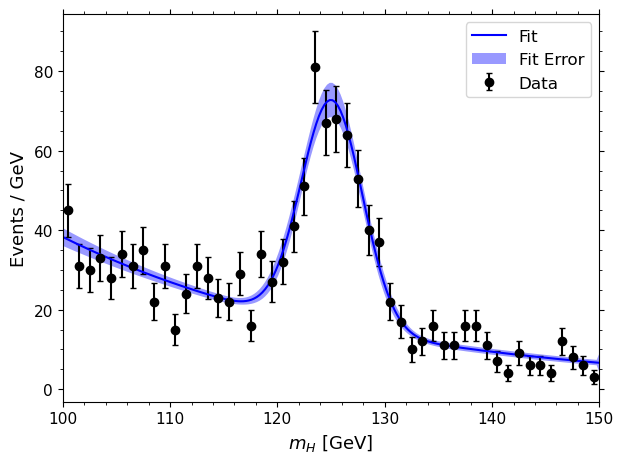

In [7]:
# generate 1000 bootstrapped values
bootstrap_pars = np.random.multivariate_normal( mi.values, mi.covariance, size=1000)

# draw the pdf and the bootstrapped error
x = np.linspace(*xrange,200)
y = tot_model(x, *mi.values)
y_boot = [ tot_model(x, *p) for p in bootstrap_pars ]
yerr_boot = np.std( y_boot, axis=0 )
 
fig, ax = plt.subplots()
nh, xe = np.histogram(data, range=xrange, bins=50)
cx = 0.5*(xe[:-1]+xe[1:])
ax.errorbar( cx, nh, nh**0.5, fmt='ko', label='Data' )
ax.plot(x, y, 'b-', label='Fit')
ax.fill_between(x, y-yerr_boot, y+yerr_boot, fc='b', alpha=0.4, label='Fit Error')

ax.legend()
ax.set_xlim(*xrange)
bw = xe[1]-xe[0]
ax.set_xlabel('$m_H$ [GeV]')
ax.set_ylabel(f'Events / GeV')

- <font color="green">*Discuss why this plot is mis-leading*</font>
- So what *would* be an appropriate use case for doing this?

## Computing systematics with bootstrapping

- This is one of the most useful applications of a bootstrap

- <font color="green">*In the lectures discuss some systematic effects*</font>
    - How do we compute these?

- *Discuss how systematic effects can be computed*
     - Try to avoid simply "*taking the difference*" from nominal an alternate scenario if possible 
     
- Discussion of <font color="blue">coverage regarding systematic uncertainties</font>
    - Try to avoid being *conservative* for the sake of it

**Bootstrapping procedure for systematic computation**
- Change an assumption in (data collection or estimation) procedure and/or modelling
- Run parametric bootstrap
    - i.e. generate under change of assumption, fit back with nominal procedure
    
- Obtain covariance matrix using covariance estimate from bootstrapped sample
$$ \text{cov}(\theta_1, \theta_2) = \frac{1}{N} \sum_{i=1}^{N} ( \theta_{1i} - \bar{\theta}_1) ( \theta_{2i} - \bar{\theta}_{2} ) $$
    - covariance matrices from different systematic effects can simply be summed

## A short discussion on nuisance parameters

- <font color="green">*Discuss in the lectures the concept of nuisance parameters*</font>
- These are parameters that float in our fit but we do not care about the value of
- The slope of our smoothly falling background is an example
- These we will often "profile over" in likelihood fits
- <font color="green">Discussion of approach here regarding Feldman-Cousins intervals</font>
    - The so-called "plugin" method
    
- In complex fits we quite often **fix** parameters (and thus propagate the uncertainty on them as a systematic)

## A quick example of running a systematic

 - let's say I have the same fit I just used above
 - but I realise I made an assumption on the parametric form of the background
     - I assumed it follows an exponential distribution
     - Perhaps I don't have physical motivation for this and want to include a systematic effect for it

- So will generate under some other assumption and then fit back to see what the systematic offset is

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6480                      │              Nfcn = 188              │
│ EDM = 4.68e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Ns   │    424    │    29     │            │            │    0    │  2000   │       │
│ 1 │ mu   │  125.01   │   0.21    │            │            │   110   │   140   │       │
│ 2 │ sg   │   2.96    │   0.21    │            │            │    0    │   10    │       │
│ 3 │ Nb   │    890    │    40     │            │            │    0    │  2000   │       │
│ 4 │ p    │    38     │     4     │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────┐
│    │       Ns       mu       sg       Nb        p │
├────┼──────────────────────────────────────────────┤
│ Ns │      872   -0.633     2.84     -448    -35.7 │
│ mu │   -0.633   0.0439  -0.0072    0.633  -0.0208 │
│ sg │     2.84  -0.0072   0.0459    -2.84   -0.211 │
│ Nb │     -448    0.633    -2.84 1.33e+03     35.7 │
│  p │    -35.7  -0.0208   -0.211     35.7     17.4 │
└────┴──────────────────────────────────────────────┘

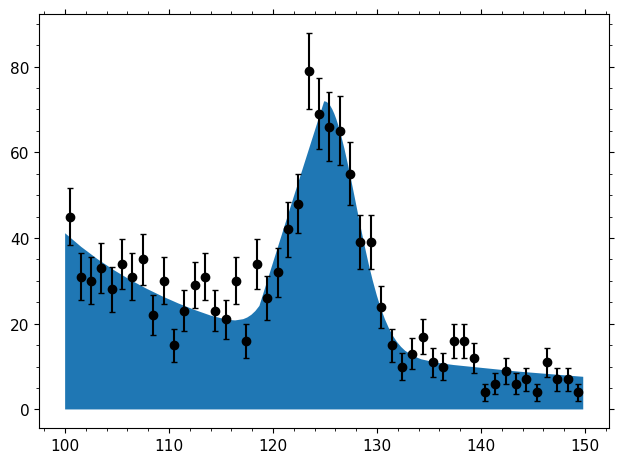

In [8]:
## Define alternate fit to data
from scipy.stats import powerlaw, truncpareto

# an alternate background model
def alt_bkg_model(p):
    scale = p
    loc = xrange[0]-scale
    c = ( xrange[1] - xrange[0] + scale ) / scale
    return truncpareto(b=1, c=c, loc=loc, scale=scale)

def alt_tot_model(x, Ns, mu, sg, Nb, p):
    return Ns*sig_model(mu,sg).pdf(x) + Nb*alt_bkg_model(p).pdf(x)

def alt_tot_density(x, Ns, mu, sg, Nb, p):
    return Ns+Nb, alt_tot_model(x, Ns, mu, sg, Nb, p)

# a generate function
def alt_generate(Ns, mu, sg, Nb, p):

    # generate poisson number of events first
    Ns = np.random.poisson(Ns)
    Nb = np.random.poisson(Nb)

    # then generate from the model
    b = alt_bkg_model(p)
    s = sig_model(mu,sg)

    bkg = b.rvs( size=Nb )
    sig = s.rvs( size=Ns )

    return np.concatenate( [bkg, sig] )

# a fit function
def alt_fit(dset):
    n2ll = cost.ExtendedUnbinnedNLL( dset, alt_tot_density )
    mi = Minuit( n2ll, Ns=450, mu=125, sg=3, Nb=900, p=8 )
    mi.limits['Ns','Nb'] = (0,2000)
    mi.limits['mu'] = (110,140)
    mi.limits['sg'] = (0,10)
    mi.limits['p'] = (0,100)
    mi.migrad()
    mi.hesse()
    return mi

alt_mi = alt_fit( data )
alt_mi.visualize()
display(alt_mi)

In [9]:
# now bootstrap from here
from tqdm import tqdm
ntoys = 250
gen_vals = list(alt_mi.values)
fit_diff = []
for i in tqdm(range(ntoys)):
    alt_toy = alt_generate(*gen_vals)
    alt_mi = alt_fit(alt_toy)
    nom_mi = fit(alt_toy)
    if alt_mi.valid and nom_mi.valid:
        fit_diff.append( np.array(nom_ mi.values) - np.array(alt_mi.values) )
    
fit_diff = np.asarray(fit_diff)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.43it/s]


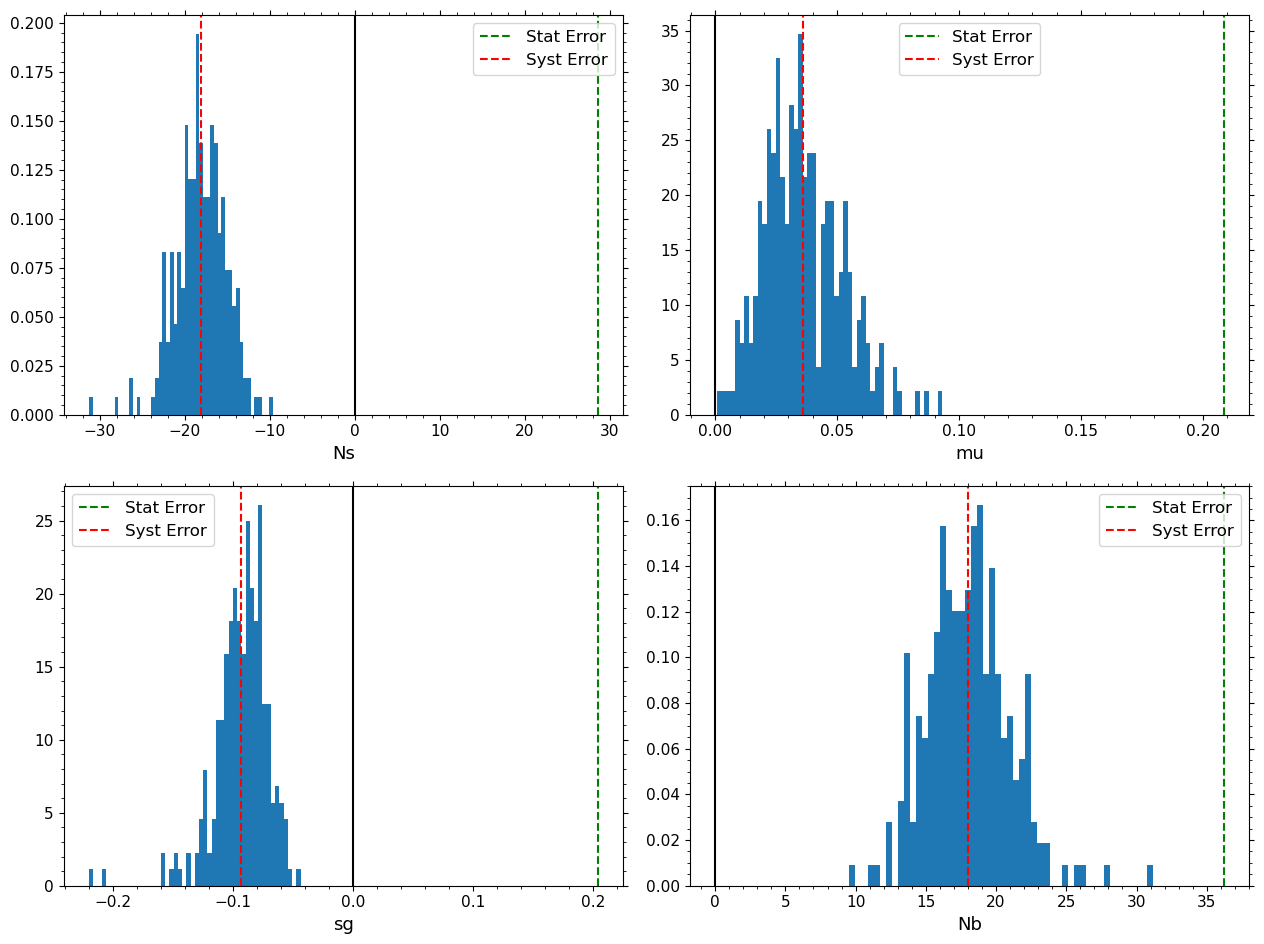

In [10]:
from scipy.stats import norm

fig, axes = plt.subplots(2, 2, figsize=(12.8, 9.6))
for (i, par), ax in zip( enumerate(['Ns','mu','sg','Nb']), axes.flatten() ):
    
    ax.hist( fit_diff[:,i], density=True, bins=50)
    ax.axvline(0, c='k')
    ax.axvline(nom_errs[i], c='g', ls='--', label='Stat Error')
    ax.axvline(np.mean(fit_diff[:,i]), c='r', ls='--', label='Syst Error')
    ax.set_xlabel(par)
    ax.legend()


## Some recommendations on systematics (in the absence of the bootstrap possibility)

- With one preferred result and one variation, quote
 
$$ R_1 \pm |R_1 - R_2| $$

- With two variations of equal status, quote

$$ \frac{R_1 + R_2}{2} \pm \bigg| \frac{R_1 - R_2}{\sqrt 2} \bigg| $$

- With N variations of equal status, quote

$$  \overline R  \pm \sqrt{\frac{N}{N-1} \big( \overline{R^2} - \overline{R}^2  \big) } $$

- With one preferred result and one extreme variation, quote

$$  R_1 \pm \frac{|R_1 - R_2|}{\sqrt{3}} $$

- With two extreme variations, quote

$$  \frac{R_1 + R_2}{2} \pm \frac{|R_1 - R_2|}{\sqrt{12}} $$

- With N extreme variations, quote

$$ \text{median}(R) \pm \frac{\max(R) - \min(R)}{\sqrt{12}} $$

## Mention the "Asimov" sample

- A very, very special (and highly useful case)
- Will cover the details in the lectures

# End of Lecture 19

By the end of this lecture you should:
   - See how resampling methods are applied
   - Understand a few principles behind computation of systematic uncertainties